# Detecting agriculture fields using satellite images

#### Using NDVI and multispectral remote sensing images

This notebook provides a short tutorial on using a spectral index such as 
Normalized Difference Vegetation index to indicate the presence (or absense) of
agricultural land use.

Spectral Indices such as NDVI can be calculated using the different bands in a 
multispectral remote sensing image.  NDVI is the normalized difference between 
the RED and NIR values:

$$NDVI = \frac{NIR - R}{NIR + R}$$

Vegetation absorbs red and reflects infrared, a high value of NDVI indicates 
heavy converage of plant material, which can indicate agricultural use.

We will use `fieldfinder` to calculate the NDVI spectral index, obtain an 
indicator mask based on a threshold, and output the mask file for use in a 
separate GIS applicaiton.


In [1]:
import numpy as np

import matplotlib.pylab as plt
import rasterio

from fieldfinder import SpectralIndex

### Create NDVI spectral index from GeoTiff
The `fieldfinder` library is designed to work with 8-band [PlanetScope Ortho Scene (3B)](https://notebook.community/planetlabs/notebooks/jupyter-notebooks/toar/toar_planetscope) images. This product consists of a GeoTiff file, along with `xml` metadata files.  The DNs in the GeoTiff file are radiance values report in units: $W*m^{-2}*sr^{-1}$.  This is a measure of how much light (over 8 wavelength bins) was captured over this spot of ground.  The type of ground cover affects the spectrum and amount of light reflecting off of it.  There are many other factors that can affect radiance, such as satellite altitude, time of day, time of year and individual satellite characteristics.  It is common to convert radiance values to 'top-of-atmosphere' reflectance to get a normalized spectral reflectance measure.  This would be essential for comparing analytic values (such as NDVI) across multiple images, or preparing datasets for machine learning.  Most spectral indices are defined in terms of reflectance, not radiance.  For analysis with a single image however, radiance values could be used.

For this tutorial, we will use the radiance values as given by the DNs in the GeoTiff file.  

Let's begin by visualizing a section from an 8b PlanetScope Ortho Scene.  Note that this image is not included in the repository. See the [Planet product specification](https://assets.planet.com/docs/Planet_Combined_Imagery_Product_Specs_letter_screen.pdf) for more details on this image product.

In [7]:
src_filename = '../data/example_AnalyticMS_8b.tif'
with rasterio.open(src_filename) as src:
    src_meta = src.meta.copy()
    src_bounds = src.bounds

    red = src.read(6)
    green = src.read(4)
    blue = src.read(2)



Use the maximum radiance value to rescale the radiances in the range 0-1.0.

In [8]:
# re-scale so each band is in the range 0-1.0

# get max radiance across all bands
max_radiance = np.max([np.nanmax(red), np.nanmax(green), np.nanmax(blue)])

red = red.astype(np.float64) / max_radiance
green = green.astype(np.float64) / max_radiance
blue = blue.astype(np.float64) / max_radiance

Arrange the red, green and blue bands into an RGB image.

In [ ]:
image = np.dstack((red, green, blue))

Let's use this to take a rough look at what this image might look like to the naked eye.

In [ ]:
plt.figure(figsize=(20,8))
plt.imshow(image)
plt.show()

It appears that there is a mixture of land coverage types in this image, including urban, fields, forests roads and water (rivers).

### Create a Spectral Index (NDVI)

Now we can use `fieldfinder` to create an NDVI spectral index.

In [10]:
ndvi = SpectralIndex(src_filename, index_type='ndvi')

Creating NDVI spectral index...


Let's take a look at the NDVI values over the image.

In [ ]:
plt.figure(figsize=(20,8))
plt.imshow(ndvi.values)
plt.colorbar()
plt.show()


The NDVI values are indeed lower over urban areas and water with little vegetation.  The outlines of fields can be seen in the western part of the image, outside the city where the NDVI values are higher.

Let's identify a threshold NDVI value to use as a cutoff to indicate the presence of fields.  There is no fixed value for this, especially since we're using radiance values for this calculation.  We'll also zoom in to a central area of the above image to see more detail.

First, use `fieldfinder` to get a mask based on a threshold:

In [16]:
ndvi_mask = ndvi.get_mask(0.68)

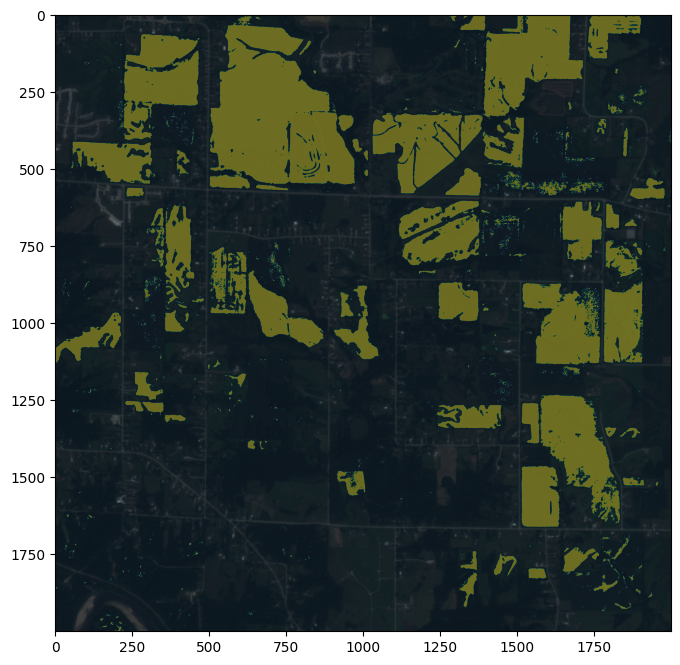

In [25]:
# zoom in to this section
section = np.s_[3000:5000, 6000:8000, :]
section_mask = (section[0], section[1])

# set alpha, and make zero values transparent
alph = 0.4 * ndvi_mask[section_mask] / 255

plt.figure(figsize=(6,6))
plt.imshow(image[section])
plt.imshow(ndvi_mask[section_mask],vmin=0, vmax=255, alpha=alph)
plt.show()



It appears that this cutoff might be a bit aggressive, and that we're missing some fields.  

Also, the very dark green areas might be forests, which could be expected to have a 
similar NDVI response as fields.

Let's reduce the NDVI mask threshold and take a look.

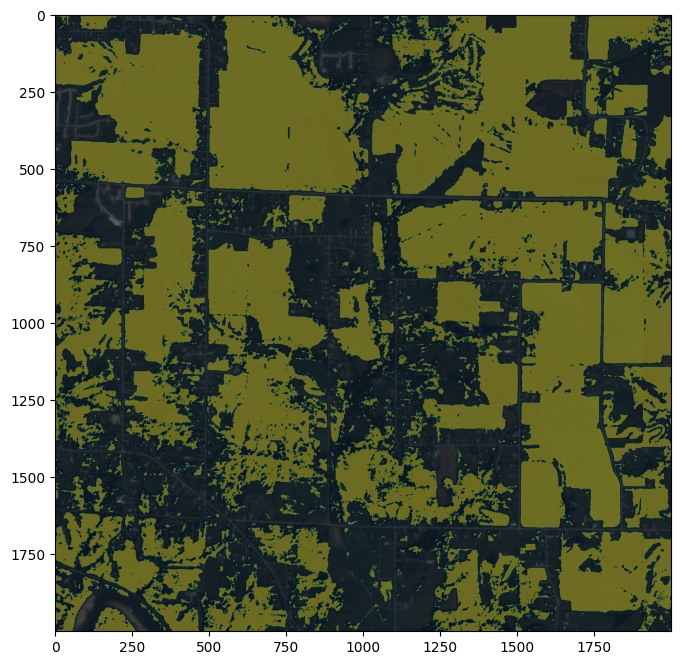

In [34]:
ndvi_mask = ndvi.get_mask(0.58)

alph = 0.4 * ndvi_mask[section_mask] / 255

plt.figure(figsize=(8,8))
plt.imshow(image[section])
plt.imshow(ndvi_mask[section_mask],vmin=0, vmax=255, alpha=alph)
plt.show()


This cutoff (NDVI >= 0.58) seems to capture more of the fields.  The roads are all dark, as is the large river is the bottom left corner of the image.

When we're satisfied with this NDVI indicator mask image, we can save it as a GeoTiff file.  We can easily write the mask to a GeoTiff file using `fieldfinder` and project it to a different CRS for easy use in another GIS application.  For example, if we want to project the mask in lat/long:

In [35]:
dst_filename = "../data/ndvi_mask_AnalyticMS_8b.tif"
ndvi.write_mask(dst_filename, threshold=0.58, out_proj='EPSG:4326')

Note that if you want to calculate a spectral index, create a mask and save an output file in one step, you can use the
convenience function `create_mask_file()`:

In [ ]:
SpectralIndex.create_mask_file(
    src_filename, 
    dst_filename, 
    threshold=0.58, 
    out_proj='EPSG:4326', 
    index_type='ndvi')